# Modelling a more realistic scenario with Monte Carlo

In this notebook, I attempt to reproduce the section "Applying the Model to a Real-life Situation" from page 137 of Haghani & White's "The Missing Billionaires".

My aim is that, if we can reproduce the figures of the more realistic scenario, then perhaps we've built a useful tool that can be tweaked for a user's individual circumstances.

The scenario is as follows. We are trying to simulate optimal investment and consumption of Sam, a 65-year-old woman, retired, with savings of \$1,000,000. We know the following about Sam:

- She has an after-tax income of \$30,000 per year. 
- We assume that her "subsistence consumption" is also \$30,000 per year.
- She would like to bequest 10 years of optimal spending after she dies
- She has 40% of her wealth in a tax shelter (Roth IRA)
- She has a rate of time preference of 2%
- She has a risk aversion of $\gamma=2$

The scenario makes the following assumptions about the investment environment:
- Safe asset return of 4% 
- Stock market expected return 9%
- Stock market risk 20%
- Inflation rate 2%
- Average tax rate 20%

An "exact" way to simulate this would be with dynamic programming. However, the decision space is quite large, making a dynamic programming approach difficult to simulate due to high dimensionality. Instead, we simulate individual life trajectories, moving forwards through time, and calculate expected lifetime utility. 

In principle, we can tweak policies and monitor expected lifetime utility, in an attempt to maximize it. For now, I'll be satisfied with simply reproducing the results on p140 of Haghani & White.

I've had to fill in the blanks at various points from the text. One key assumption I am making is that optimal consumption given a bequest, goes from 

$$\hat{c}_t = \frac{\hat{c}_\infty}{1 - (1 + \hat{c}_\infty)^{-T}}$$

to 

$$\hat{c}_t = \frac{\hat{c}_\infty}{1 - (1 + \hat{c}_\infty)^{-(T+b)}}$$

given a bequest paramter $b$, whose interpretation is

> the number of years of spending, at the rate of her last year of optimal spending, that she wants to leave to her family

In [1]:
import numpy as np
from polars import col
import matplotlib.pyplot as plt
import seaborn as sb
import polars as pl
from findec.visualise import quantile_lineplot

In [2]:
%load_ext autoreload
%autoreload 2
plt.style.use("../matplotlibrc")

In [3]:
from findec.returns import RiskyAsset, DistributionType
from findec.utility import composite_crra_utility
from findec.simulate import simulate_life_paths
from findec.assets import Assets
from findec.dataclasses import Preferences

## Visualise personal utility function

In [4]:
preferences = Preferences()

To model subsistence, we simply make risk aversion higher when wealth is below the subsistence level. I also have a floor to utility, so that utility does not diverge to $-\infty$. In the plot below I plot the same utility function over two different scales.

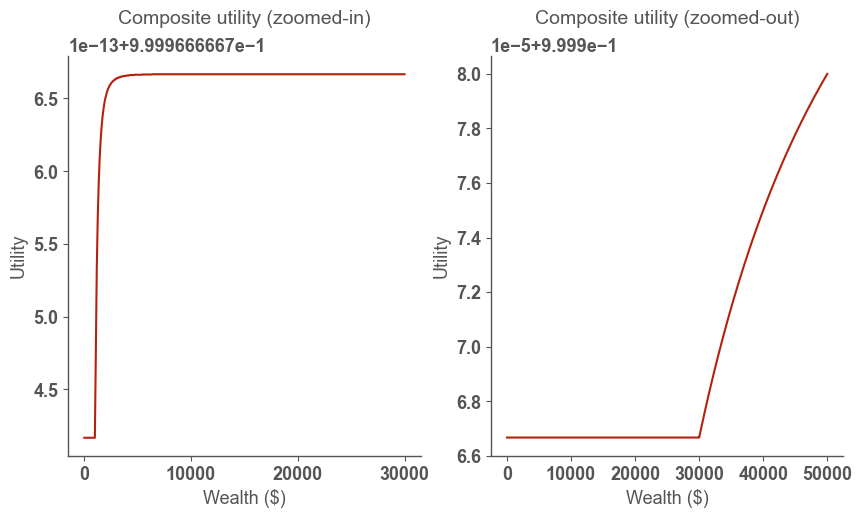

In [5]:
fig, axs = plt.subplots(ncols=2, figsize=(2*5., 5.))
axs = axs.ravel()

ax = axs[0]
w = np.linspace(0, 30e3, 1000)
u = np.array([composite_crra_utility(wi, pref=preferences) for wi in w])
ax.plot(w, u)
ax.set_title("Composite utility (zoomed-in)")
ax.set_xlabel("Wealth ($)")
ax.set_ylabel("Utility")

ax = axs[1]
w = np.linspace(0, 50e3, 1000)
u = np.array([composite_crra_utility(wi, pref=preferences) for wi in w])
ax.plot(w, u)
ax.set_title("Composite utility (zoomed-out)")
ax.set_xlabel("Wealth ($)")
ax.set_ylabel("Utility");

In practice, all we need is a wealth $\rightarrow \gamma$ mapping. The full composite utility function doesn't really enter into the simulation anywhere. 

## Visualise stock returns

Our policy only depends on the mean and standard deviation of returns. There are lots of choices we could make about the distribution. Below I compare normal and log-normal returns when matched to the same two moments. We see there's not a lot in it, so I'll just use normally-distributed returns in the proper simulation.

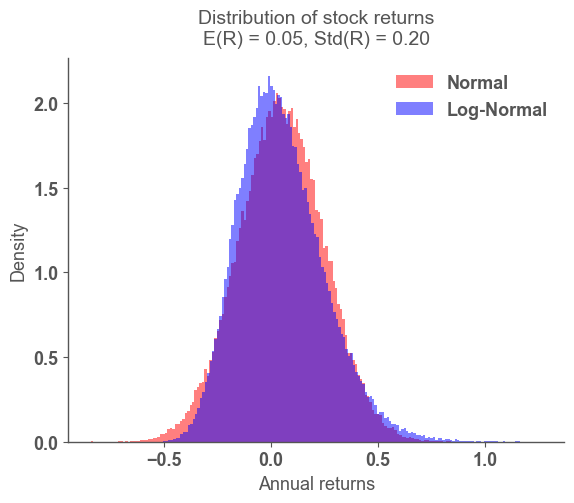

In [6]:
fig, ax = plt.subplots()

stock_returns = RiskyAsset(
    expected_return=0.05,
    standard_deviation=0.2,
    distribution_type=DistributionType.NORMAL,
).draw(n_draws=100_000)
ax.hist(stock_returns, bins="auto", density=True, label="Normal", alpha=0.5, color="red")
stock_returns_mean = stock_returns.mean()
stock_returns_std = stock_returns.std()
ax.set_xlabel("Annual returns")
ax.set_ylabel("Density")

stock_returns = RiskyAsset(
    expected_return=0.05,
    standard_deviation=0.2,
    distribution_type=DistributionType.LOG_NORMAL,
).draw(n_draws=100_000)
ax.hist(stock_returns, bins="auto", density=True, label="Log-Normal", alpha=0.5, color="blue")
stock_returns_mean = stock_returns.mean()
stock_returns_std = stock_returns.std()
ax.set_xlabel("Annual returns")
ax.set_ylabel("Density")

ax.set_title(
    f"Distribution of stock returns\nE(R) = {stock_returns_mean:.2f}, Std(R) = {stock_returns_std:.2f}"
)

ax.legend();

## A small-scale simulation (fixed time horizon)

Just to take a look at some trajectories, let's first simulate a small number of life paths, over exactly 20 years (so no longevity uncertainty)

In [7]:
initial_assets = Assets(
    tax_free=400_000.0, taxable=600_000.0, inflation_rate=0.02
)
preferences = Preferences(bequest_param=10)

sims = simulate_life_paths(
    n_sims=10,
    expected_return_risky=0.09,
    std_dev_return_risky=0.20,
    risk_free_rate=0.04,    
    tax_rate=0.2,
    pref=preferences,
    assets=initial_assets,
    social_security=30_000.0,
    time_horizon_max=20,
    starting_age=65,
    is_male=False,
    rng_seed_offset=42,
    with_longevity_uncertainty=False,
    returns_distribution_type=DistributionType.NORMAL,
)

100%|██████████| 10/10 [00:00<00:00, 229.01it/s]


Text(0.5, 1.0, 'Small-scale simulation without longevity uncertainty')

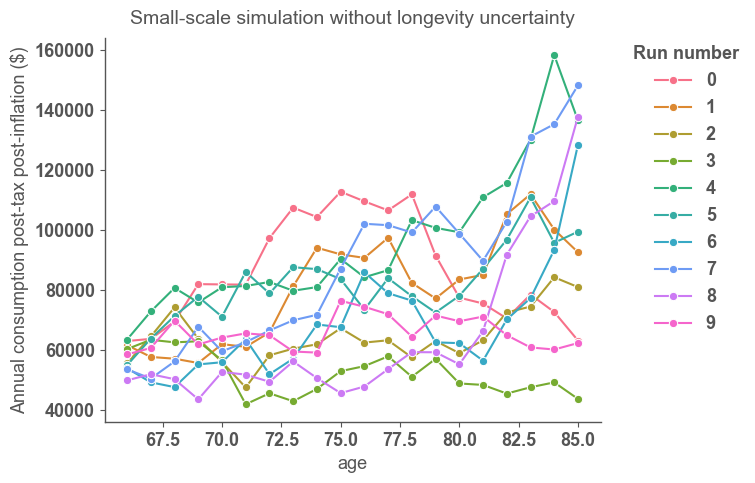

In [8]:
ax = sb.lineplot(
    sims, x="age", y="consumption_post_tax_post_inflation", hue="run_number", marker="o"
)
plt.legend(
    bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0, title="Run number"
)
ax.set_ylabel("Annual consumption post-tax post-inflation ($)");
ax.set_title("Small-scale simulation without longevity uncertainty")

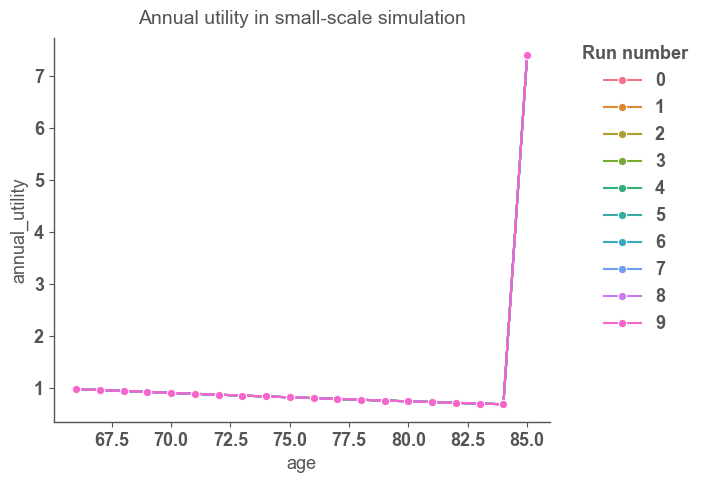

In [9]:
ax = sb.lineplot(sims, x="age", y="annual_utility", hue="run_number", marker="o")
ax.set_title("Annual utility in small-scale simulation")
plt.legend(
    bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0, title="Run number"
);

We see that utility annually decreases through time, due to discounting the future by time-preference, but has a peak at the end of life due to the 10-year bequest.

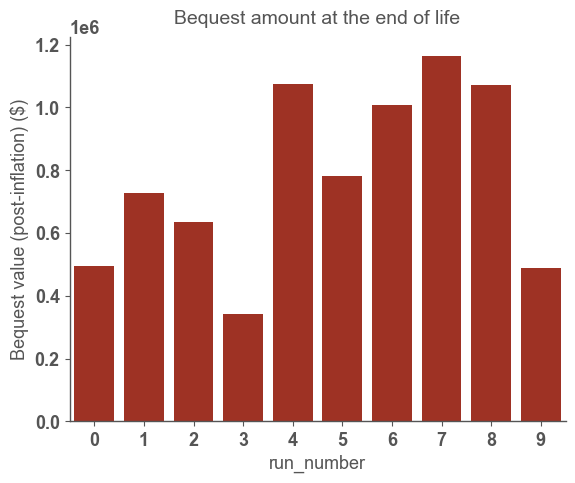

In [10]:
ax = sb.barplot(
    sims.sort("age")
    .group_by("run_number")
    .agg(col("bequest_post_inflation").last())
    .sort("run_number"),
    x="run_number",
    y="bequest_post_inflation",
)
ax.set_ylabel("Bequest value (post-inflation) ($)")
ax.set_title("Bequest amount at the end of life");

## Larger-scale sim

In this section I try to get as close as I can to the figures in Exhibit 9.1 on p140 of The Missing Billionaires.

In [11]:
initial_assets = Assets(tax_free=400_000.0, taxable=600_000.0, inflation_rate=0.02)
preferences = Preferences(bequest_param=10, rate_time_preference=0.02)

sims = simulate_life_paths(
    n_sims=100_000,
    expected_return_risky=0.09,
    std_dev_return_risky=0.20,
    risk_free_rate=0.04,
    tax_rate=0.2,
    pref=preferences,
    assets=initial_assets,
    social_security=30_000.0,
    time_horizon_max=35,
    starting_age=65,
    is_male=False,
    rng_seed_offset=42,
    with_longevity_uncertainty=True,
    returns_distribution_type=DistributionType.NORMAL,
)

100%|██████████| 100000/100000 [01:40<00:00, 992.77it/s]


In [12]:
with pl.Config(tbl_rows=50):
    display(
        sims.group_by("age")
        .agg(
            col("consumption_post_tax_post_inflation")
            .quantile(0.5)
            .alias("median_consumption_post_tax_post_inflation"),
            col("consumption_fraction")
            .quantile(0.5)
            .alias("median_consumption_fraction"),
        )
        .sort("age")
    )

age,median_consumption_post_tax_post_inflation,median_consumption_fraction
i64,f64,f64
65,null,null
66,61226.412888,0.057376
67,62199.808041,0.058238
68,63111.861281,0.05914
69,64068.014881,0.060083
70,65031.088381,0.061085
71,66038.013953,0.062135
72,66939.398286,0.063221
73,67812.703482,0.064376


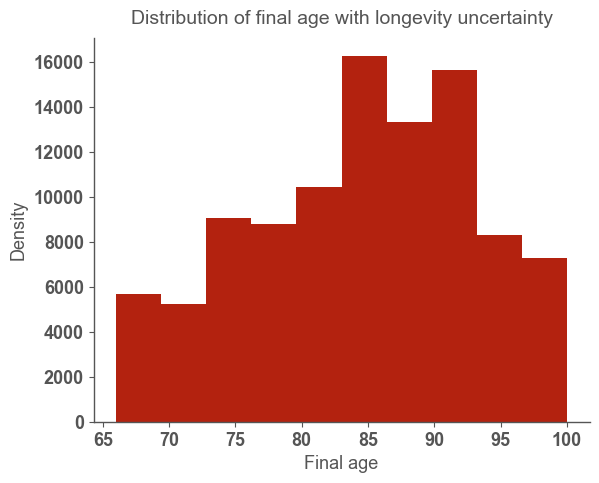

In [13]:
fig, ax = plt.subplots()
ax.hist(sims.group_by("run_number").agg(col("age").last())["age"])
ax.set_xlabel("Final age")
ax.set_ylabel("Density")
ax.set_title("Distribution of final age with longevity uncertainty");

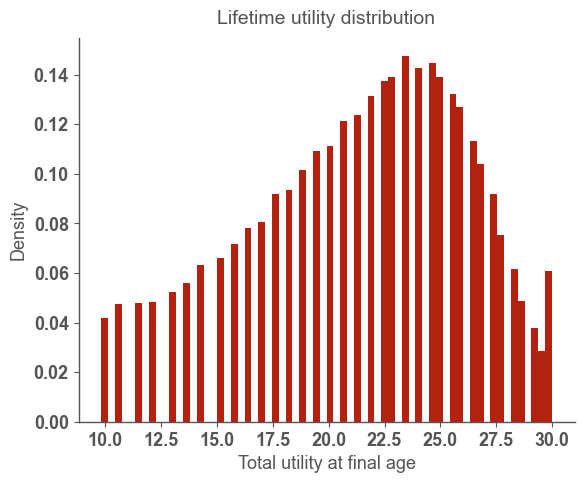

In [14]:
fig, ax = plt.subplots()
ax.hist(
    sims.sort("age")
    .group_by("run_number")
    .agg(col("total_utility").last())["total_utility"],
    bins="auto",
    density="True",
)
ax.set_xlabel("Total utility at final age")
ax.set_ylabel("Density")
ax.set_title("Lifetime utility distribution");

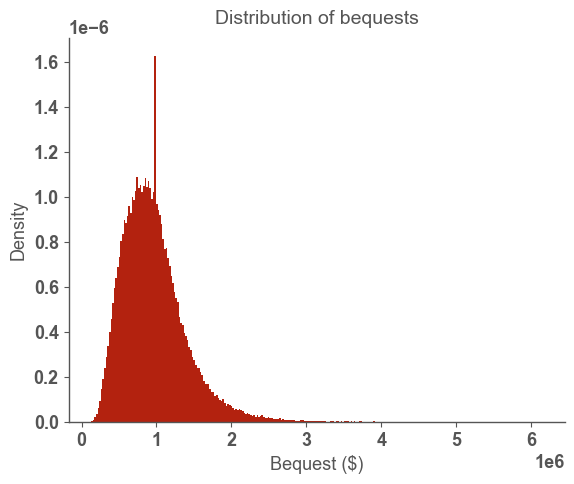

In [15]:
fig, ax = plt.subplots()
ax.hist(
    sims.sort("age")
    .group_by("run_number")
    .agg(col("bequest_post_inflation").last())["bequest_post_inflation"],
    bins="auto",
    density="True",
)
ax.set_xlabel("Bequest ($)")
ax.set_ylabel("Density")
ax.set_title("Distribution of bequests");

The figure below tries to replicate the top panel of Exhibit 9.1, "Spending net of subsistence".

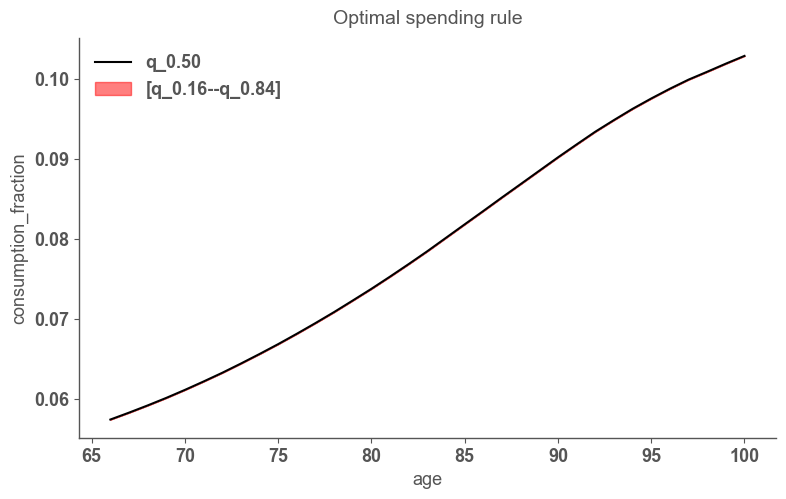

In [16]:
fig, ax = plt.subplots(figsize=(9, 5))
ax = quantile_lineplot(
    sims,
    x="age",
    y="consumption_fraction",
    ax=ax,
    quantiles=[0.16, 0.5, 1 - 0.16],  # 1 std dev under normal approximation
)
ax.set_title("Optimal spending rule");

My calculations of optimal spending rules are slightly different compared with the figure in the book, but roughly the right ballpark.

The figure below tries to replicate the middle panel of Exhibit 9.1, "Spending statistics". 

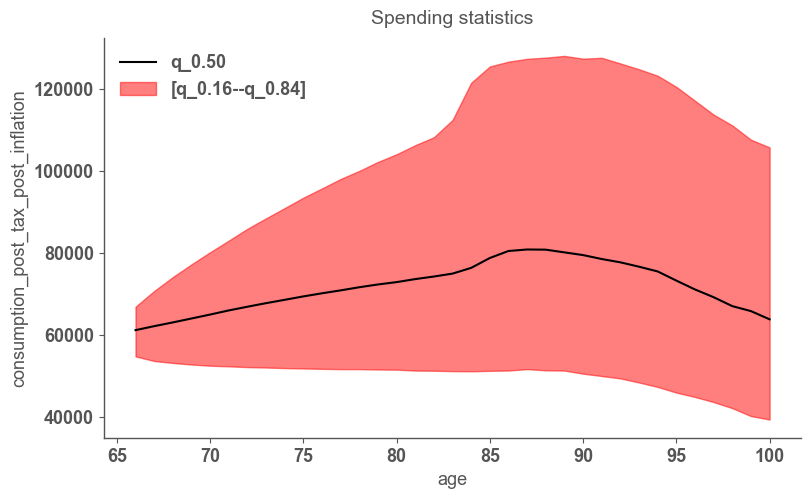

In [17]:
fig, ax = plt.subplots(figsize=(9, 5))
ax = quantile_lineplot(
    sims,
    x="age",
    y="consumption_post_tax_post_inflation",
    ax=ax,
    quantiles=[0.16, 0.5, 1 - 0.16],  # 1 std dev under normal approximation
)
ax.set_title("Spending statistics");


I'm getting initial spending to be slightly lower than the book, median consumption in the first year is more like 60k than 70k in the book, but still roughly the right ballpark in terms of distribution shape.

The figure below tries to replicate the lower panel of Exhibit 9.1, "Portfolio Value".

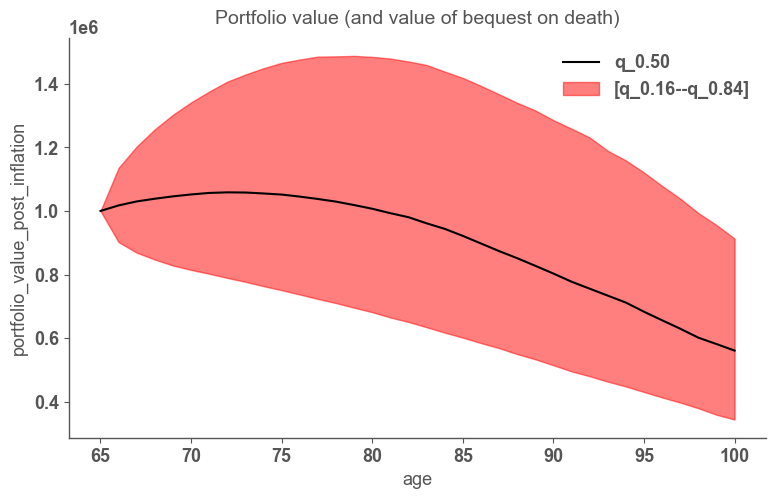

In [18]:
fig, ax = plt.subplots(figsize=(9, 5))

ax = quantile_lineplot(
    sims,
    x="age",
    y="portfolio_value_post_inflation",
    quantiles=[0.16, 0.5, 1 - 0.16],  # 1 std dev under normal approximation
    ax=ax,
)
ax.set_title("Portfolio value (and value of bequest on death)");

This chart is pretty close to the book.

## Back-of-the-envelope

Checking my maths for the first year of consumption

In [19]:
r_f = 0.04
r_i = 0.02
mu = 0.09 - r_f
sigma = 0.2 
gamma=2

k = mu/gamma/sigma**2
k  # correct, according to p139, "the optimal allocation does remain roughly constant at about 62%"

0.6249999999999998

In [20]:
r_ra = r_f + k*(mu - k*gamma*sigma**2/2)
r_ra

0.055624999999999994

In [21]:
r_tp = 0.02

c_infty = r_ra - (r_ra - r_tp)/gamma
c_infty

0.0378125

In [22]:
T = 20
c_t = c_infty / (1-(1+c_infty)**-T)
c_t

0.07216353905907746

And then with my assumption about how to handle bequests

In [23]:
T = 20
b = 10
c_t = c_infty / (1-(1+c_infty)**-(T+b))
c_t

0.05630401200144537